In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
input_dir = "../data/images"
trimap_dir = "../data/annotations/trimaps"

input_image_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
)

trimap_image_paths = sorted(
    [os.path.join(trimap_dir,fname) for fname in os.listdir(trimap_dir)
        if fname.endswith(".png") and not fname.startswith(".")]
)

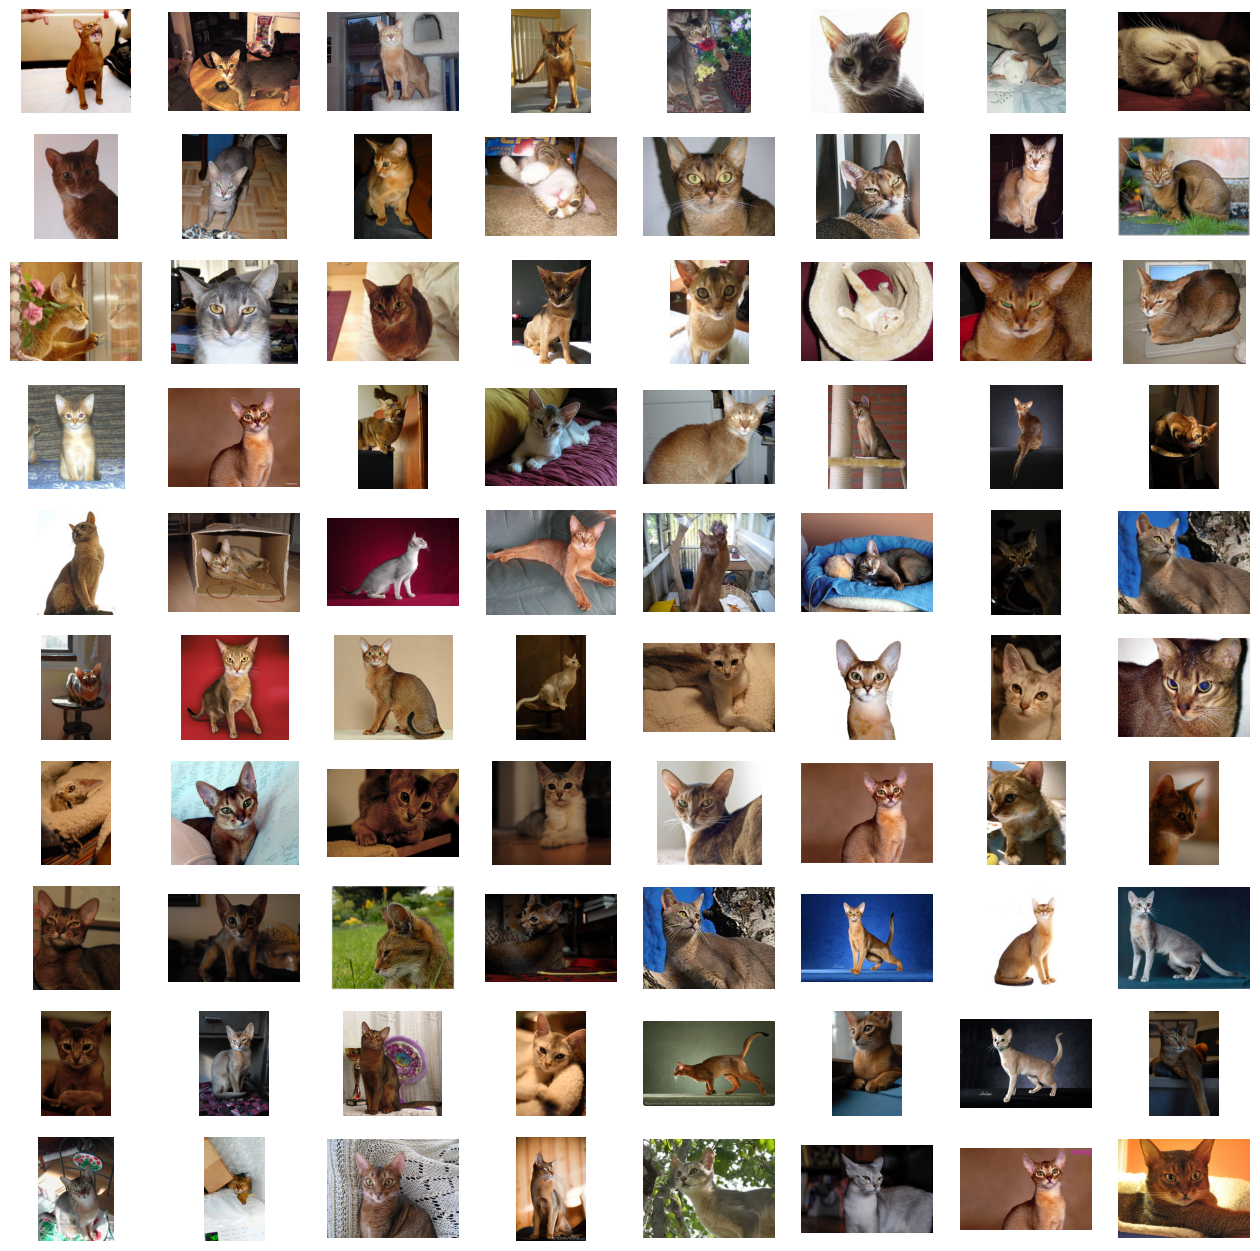

In [3]:
fig = plt.figure(figsize=(16, 16))
columns = 8
rows = 10
for i in range(1, columns * rows + 1):
    img = load_img(input_image_paths[i+100])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8")-1)*127
    plt.axis("off")
    plt.imshow(normalized_array[:,:,0])

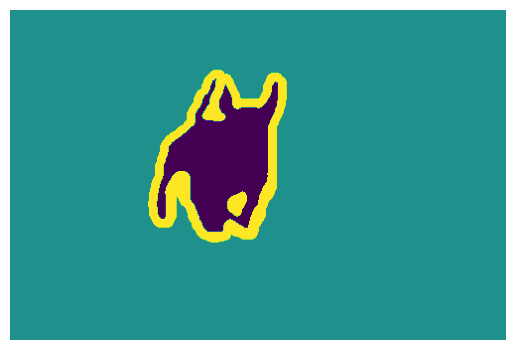

In [15]:
img = img_to_array(load_img(trimap_image_paths[6500], color_mode = "grayscale"))
display_target(img)

In [17]:
import glob
import xml.etree.ElementTree as ET

In [25]:
SPLIT_RATIO = 0.8
XMLS = "../data/annotations/xmls"

In [26]:
class_names = {}
k = 0
output = []
xml_files = glob.glob("{}/*xml".format(XMLS))
for i, xml_file in enumerate(xml_files):
    tree = ET.parse(xml_file)

    path = os.path.join(XMLS, tree.findtext("./filename"))

    height = int(tree.findtext("./size/height"))
    width = int(tree.findtext("./size/width"))
    xmin = int(tree.findtext("./object/bndbox/xmin"))
    ymin = int(tree.findtext("./object/bndbox/ymin"))
    xmax = int(tree.findtext("./object/bndbox/xmax"))
    ymax = int(tree.findtext("./object/bndbox/ymax"))

    basename = os.path.basename(path)
    basename = os.path.splitext(basename)[0]
    class_name = basename[:basename.rfind("_")].lower()
    if class_name not in class_names:
        class_names[class_name] = k
        k += 1

    output.append((path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]))
output.sort(key=lambda tup : tup[-1])

In [ ]:
lengths = []
i = 0
last = 0
for j, row in enumerate(output):
    if last == row[-1]:
        i += 1
    else:
        print("class {}: {} images".format(output[j-1][-2], i))
        lengths.append(i)
        i = 1
        last += 1

print("class {}: {} images".format(output[j-1][-2], i))
lengths.append(i)

In [3]:
import numpy as np
import random

img_size = (200,200)
num_imgs = len(input_image_paths)

random.Random(1337).shuffle(input_image_paths)
random.Random(1337).shuffle(trimap_image_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size = img_size, color_mode = "grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32")

targets = np.zeros((num_imgs,) + img_size + (1,), dtype = "uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_image_paths[i])
    targets[i] = path_to_target(trimap_image_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [4]:
import model

In [5]:
seg = model.segment((200,200,3), 3)

Encoding Completed... Beginning Decoding.


ValueError: in user code:

    /Users/joedodson/Documents/CS1470/pupquiz/segment/layers.py:54 call  *
        ret = tf.scatter_nd(tf.expand_dims(tf.keras.layers.Flatten()(mask), -1),
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:9021 scatter_nd  **
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions [0,2) of indices[shape=[?,86528,1]] = [?,86528] must match dimensions [0,2) of updates[shape=[?,100352]] = [?,100352]: Dimension 1 in both shapes must be equal, but are 86528 and 100352. Shapes are [?,86528] and [?,100352]. for '{{node max_unpool2d_1/ScatterNd}} = ScatterNd[T=DT_FLOAT, Tindices=DT_INT32](max_unpool2d_1/ExpandDims, max_unpool2d_1/flatten_1/Reshape, max_unpool2d_1/ScatterNd/shape)' with input shapes: [?,86528,1], [?,100352], [1].


In [7]:
seg = model.segment((200,200,3), 3)

print("made model")

seg.compile(optimizer ="rmsprop",
              loss = "sparse_categorical_crossentropy")

print("compiled")
              
#seg.fit(train_input_imgs, train_targets, epochs=50, batch_size=64, validation_data=(val_input_imgs, val_targets))

conv1


TypeError: in user code:

    /Users/joedodson/Documents/CS1470/pupquiz/segment/layers.py:95 call  *
        conv2 = self.conv2D_2(conv1)
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/joedodson/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/input_spec.py:196 assert_input_compatibility
        raise TypeError('Inputs to a layer should be tensors. Got: %s' % (x,))

    TypeError: Inputs to a layer should be tensors. Got: <keras.layers.advanced_activations.LeakyReLU object at 0x2932aaf10>
